In [1]:
import sys
sys.path.append(r'../')

import setup.configurations
from setup.parameters import class_names, image_size, n_folds, n_classes
from setup.data_loader import load_data, preprocessing

from utils.visualization import *
from utils.utils import make_gradcam_heatmap, convert_labels_to_indices, calculate_class_weights
from utils.training import get_training_callbacks, run_cross_validation

from models.model import get_model

from keras.models import load_model

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve, average_precision_score

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from itertools import cycle

In [2]:
training_images = []
training_labels = []
test_images = []
test_labels = []

training_images, training_labels, test_images, test_labels = load_data(class_names)

100%|██████████| 1426/1426 [00:04<00:00, 285.71it/s]


In [3]:
# Calculate the class weights to avoid class imbalance
class_weights = calculate_class_weights(training_labels)
print(class_weights)

{0: 1.212938596491228, 1: 1.032673637042569, 2: 0.8669278996865204, 3: 0.9490391214824982}


In [4]:
# Convert training and test labels to unique indices
training_labels, test_labels = convert_labels_to_indices(training_labels, test_labels)

In [5]:
print_class_statistics(training_labels, class_names, "Training")
print_class_statistics(test_labels, class_names, "Test")

Training:
    Total: 5531
    glioma: 1140 (20.61% of total)
    meningioma: 1339 (24.21% of total)
    notumor: 1595 (28.84% of total)
    pituitary: 1457 (26.34% of total)
Test:
    Total: 1297
    glioma: 286 (22.05% of total)
    meningioma: 306 (23.59% of total)
    notumor: 405 (31.23% of total)
    pituitary: 300 (23.13% of total)


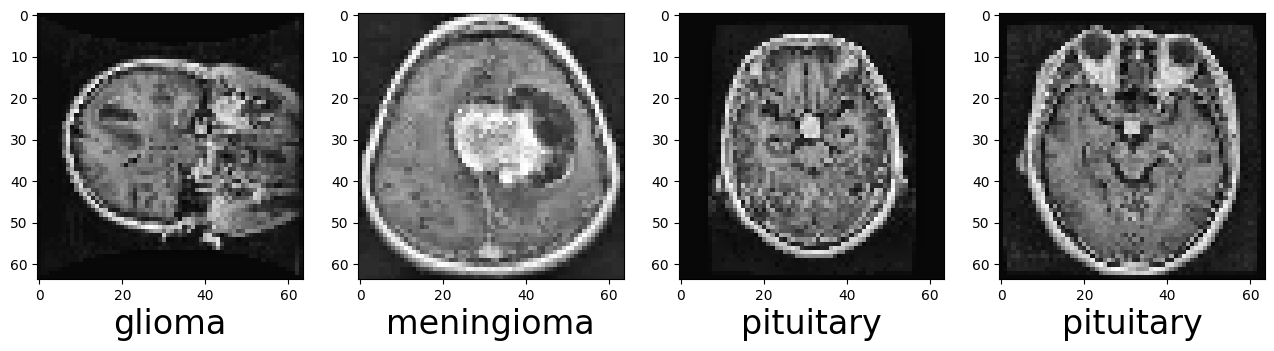

In [6]:
# Plot image examples for sanity check
plot_random_image_examples(training_images, training_labels, class_names, num_examples=4)

In [7]:
callbacks = get_training_callbacks()

In [8]:
model_history = run_cross_validation(n_folds, training_images, training_labels, class_weights, callbacks)

Training on Fold:  1
Epoch 1/60
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4891 - loss: 1.4779
Epoch 1: val_accuracy improved from -inf to 0.87082, saving model to ../weights/weights.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.4911 - loss: 1.4728 - val_accuracy: 0.8708 - val_loss: 0.5913 - learning_rate: 0.0010
Epoch 2/60
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8465 - loss: 0.5930
Epoch 2: val_accuracy improved from 0.87082 to 0.87805, saving model to ../weights/weights.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8466 - loss: 0.5926 - val_accuracy: 0.8780 - val_loss: 0.5182 - learning_rate: 0.0010
Epoch 3/60
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8837 - loss: 0.4628
Epoch 3: val_accuracy improved from 0.87805 to 0.90154, saving model to ../weights/weights.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.8838 - loss: 0.4627 - val_accuracy: 0.9015 - val_loss: 0.4428 - learning_rate: 0.0010
Epoc

In [9]:
# Load the trained model
model = load_model('../weights/weights.keras')

In [10]:
# Evaluate the model on the test data
results = model.evaluate(test_images, test_labels)

# Make predictions on the test data
model_prediction = model.predict(test_images)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9555 - loss: 0.2077
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [11]:
# Convert predictions to class labels
predicted_classes = np.argmax(np.round(model_prediction), axis = 1)

# Print the classification report
print(classification_report(test_labels, predicted_classes, target_names = class_names))

              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       286
  meningioma       0.99      0.93      0.96       306
     notumor       0.97      1.00      0.99       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.98      1297
   macro avg       0.98      0.98      0.98      1297
weighted avg       0.98      0.98      0.98      1297



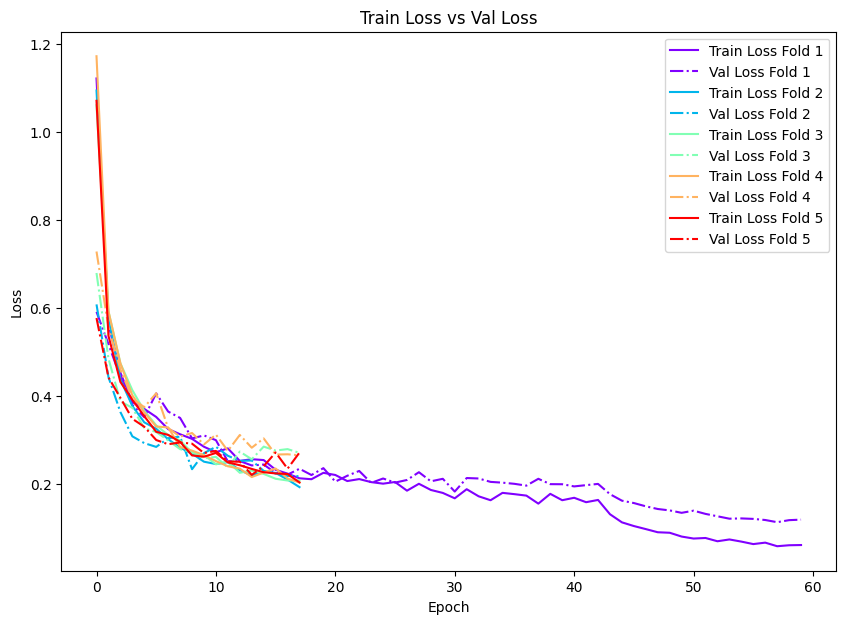

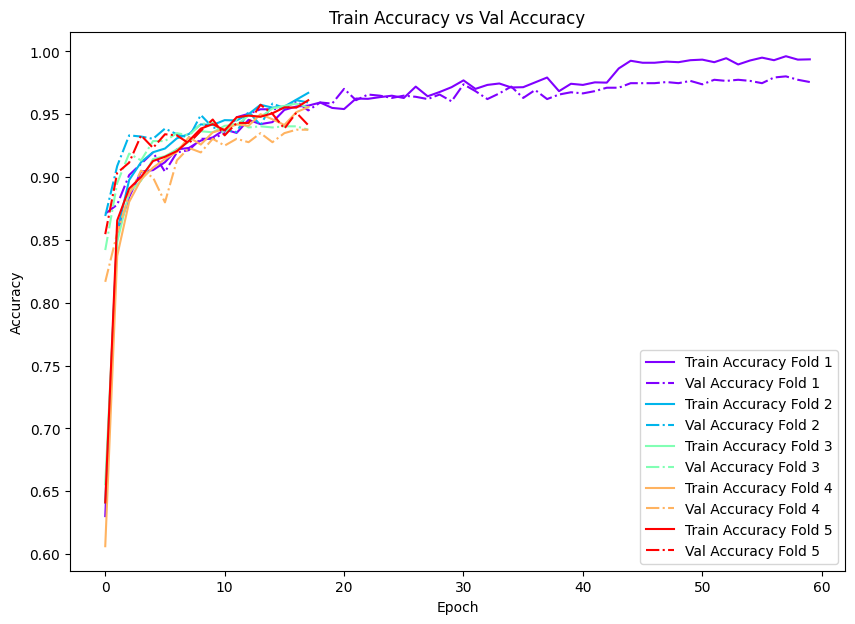

In [12]:
# Plot the loss metrics from the model history
plot_metrics(model_history, 'Loss', 'Loss', n_folds, linestyle='dashdot')

# Plot the accuracy metrics from the model history
plot_metrics(model_history, 'Accuracy', 'Accuracy', n_folds, linestyle='dashdot')

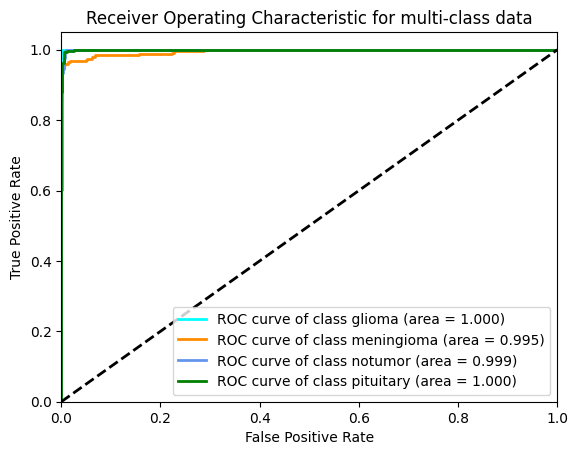

In [13]:
fpr = dict()
tpr = dict()
roc_auc = dict()

test_labels_bin = label_binarize(test_labels, classes=[0, 1, 2, 3])

# Calculate ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], model_prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

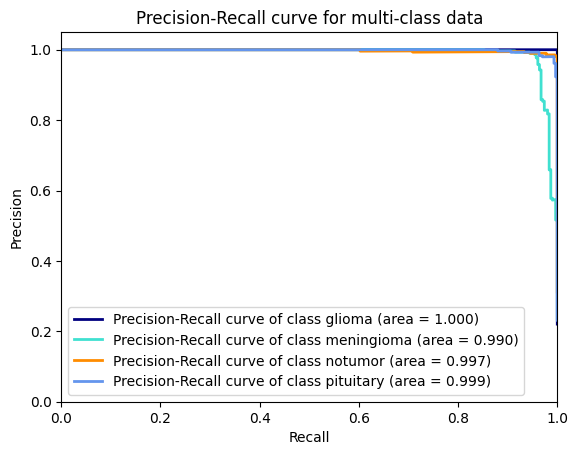

In [14]:
precision = dict()
recall = dict()
average_precision = dict()

# Calculate precision, recall, and average precision for each class
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_labels_bin[:, i], model_prediction[:, i])
    average_precision[i] = average_precision_score(test_labels_bin[:, i], model_prediction[:, i])

colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Precision-Recall curve of class {class_names[i]} (area = {average_precision[i]:0.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall curve for multi-class data')
plt.legend(loc="lower left")
plt.show()

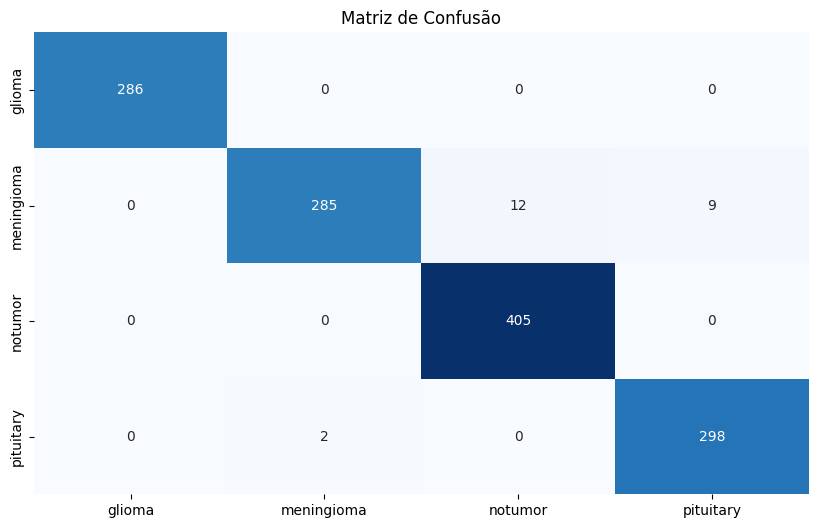

In [15]:
# Create confusion matrix
cmat = confusion_matrix(test_labels, predicted_classes)
cm_df = pd.DataFrame(cmat)

# Create DataFrame for confusion matrix with class names as index and column names
cmat_df = pd.DataFrame(cmat,
                       index=class_names,
                       columns=class_names)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cmat, annot=True, cmap='Blues', fmt="d",
            cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.show()

In [16]:
# Specify a random test image from the validation dataset
orig_img = cv2.imread(r'..\data\validation_dataset\Testing\meningioma_tumor\image(82).jpg')  # Load the image
img = cv2.resize(orig_img, (image_size, image_size))  # Resize the image to the desired size
img = preprocessing(img)  # Apply preprocessing steps
img = img.astype('float32') / 255.0  # Normalize the image to [0, 1] range
x = np.expand_dims(img, axis=0)  # Expand dimensions to fit model input requirements

In [17]:
# Make a prediction
predictions = model.predict(x)

# Convert predictions to percentages
percentages = predictions[0] * 100  # Assuming predictions are in a scale of 0 to 1

for i, class_name in enumerate(class_names):
    print(f"Probability of '{class_name}': {percentages[i]:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Probability of 'glioma': 0.01%
Probability of 'meningioma': 99.14%
Probability of 'notumor': 0.12%
Probability of 'pituitary': 0.73%


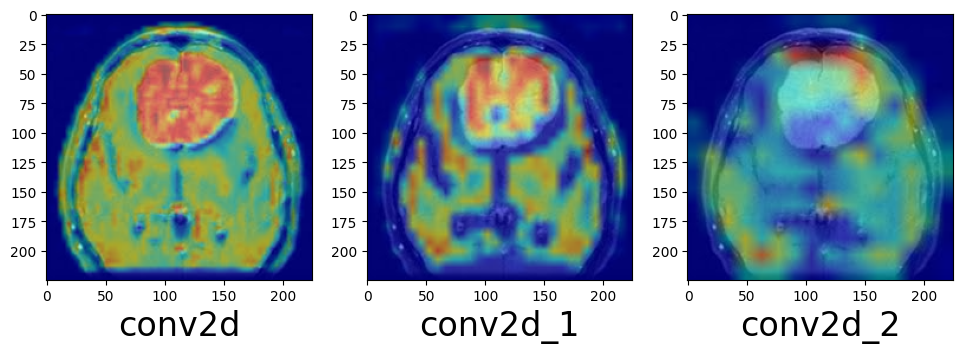

In [18]:
# Get the names of all convolutional layers
conv_layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]

plt.figure(figsize=(20,20))

counter = 0

# Iterate over each convolutional layer
for layer_name in conv_layer_names:
    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(x, model, layer_name)

    # Convert original image to RGB
    orig_img_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # Create a colored heatmap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Resize the heatmap to match the original image
    heatmap_resized = cv2.resize(heatmap_colored, (orig_img_rgb.shape[1], orig_img_rgb.shape[0]))

    # Superimpose the heatmap onto the original image
    superimposed_img = np.uint8(heatmap_resized * 0.5 + orig_img_rgb * 0.5)

    plt.subplot(5,5, counter+1)
    plt.imshow(superimposed_img)
    plt.xlabel(f'{layer_name}', fontsize=24)

    counter = counter + 1

plt.show()